In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import helper_methods
import yfinance

In [3]:
# TO DO: In a different file, find two cointegrated stocks. Those two stocks will replace KO and PEP

# Pt 1 of this file visualizes the cointegration of the 2 stocks. Pt 2 of this file researches buy and sell signals

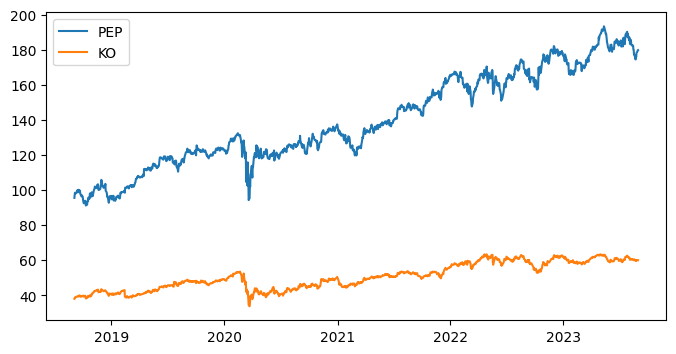

In [4]:
# Pt 1: Begin Visualizing cointegration

# Plot the two assets
df_1 = helper_methods.get_stock_prices("PEP", "2018-09-01", "2023-08-31")
df_2 = helper_methods.get_stock_prices("KO", "2018-09-01", "2023-08-31")
stock_1 = df_1['Close']
stock_2 = df_2['Close']

# Note: need to change the labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1, label = 'PEP')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

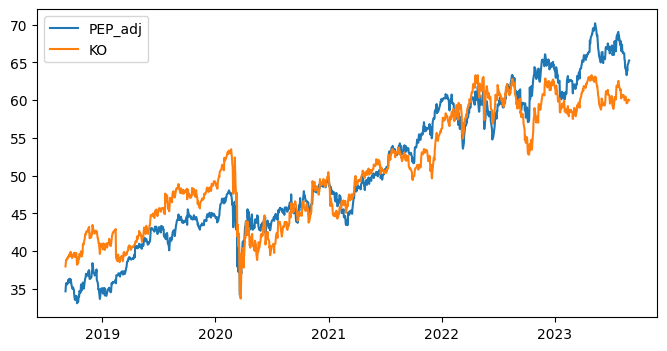

In [5]:
# We can see that PEP and KO roughly move together, but to see this better, let's normalize them to see them right next to each other
stock_1_adjusted = stock_1 / (np.mean(stock_1) / np.mean(stock_2))

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1_adjusted, label = 'PEP_adj')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

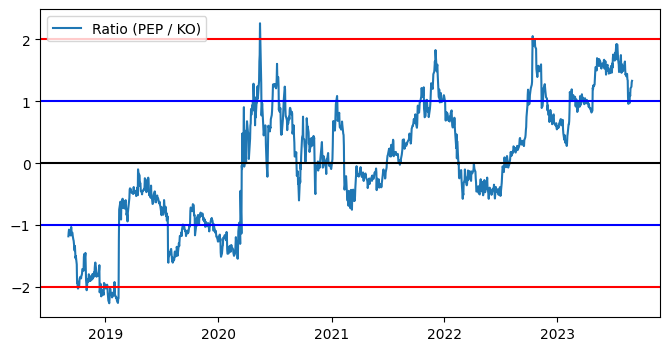

In [6]:
# Use ratios to calculate spread
ratio = stock_1 / stock_2

# Normalize the series
z_score = (ratio - ratio.mean()) / ratio.std()

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z_score, label = 'Ratio (PEP / KO)')
plt.axhline(z_score.mean(), color = 'black')

# 68% of the data lies within 1 standard deviation
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')

# 95% of data lies within 2 standard deviations from mean
plt.axhline(2.0, color = 'red')
plt.axhline(-2.0, color = 'red')

ax.legend()
plt.show()


# This ratio appears stationary (not entirely, but if we find a better cointegrated pair it should appear more stationary)
# Note that this visualization does have look ahead bias. For example, the z score threshold in 2020 takes into account data from 2022.

In [7]:
# Pt 2: Begin signal research

# Split train and test data
train = ratio[0:round(.8*len(ratio))]
test = ratio[round(.8*len(ratio)):]

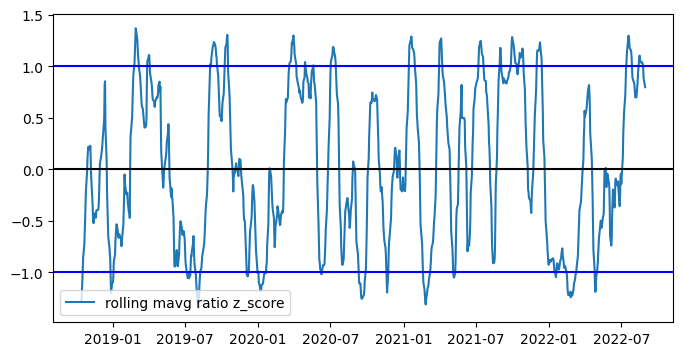

In [8]:
# Adjust the graph to moving average to avoid look ahead bias (we might want to adjust the windows later)
def mavg_z_score(data): # Add this function to helper_methods
    # 1 day moving avg represents our current mean
    mavg_10_day = data.rolling(window=10).mean()

    # 30 day moving avg represents our historical mean
    mavg_30_day = data.rolling(window=30).mean()
    std_30_day = data.rolling(window=30).std()

    # Calculate z-score for difference between current and historical mean
    z_score_30vs10 = (mavg_10_day - mavg_30_day) / std_30_day

    return z_score_30vs10


# Plot new graph based off moving avg
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(mavg_z_score(train), label = 'rolling mavg ratio z_score')
plt.axhline(0, color = 'black')
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')
plt.legend()
plt.show()

# Note that this graph's signals don't look as powerful as the previous graph, but that is because we don't have look ahead bias here
# Also note that this data will not follow the 68/95/99 rule because we are comparing the current moving average to the standard deviation of a longer moving average.
# Ratios further from a mean still signal divergence, but just not at the exact percentages of 68/95/99


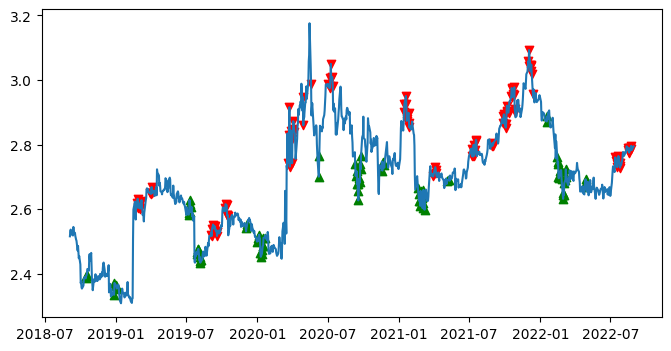

In [137]:
# With the graph above, we will want to trade the spread when the rolling moving average ratio moves outside the blue band.
# If the value is above the band, that means that stock_1 (PEP) is overvalued compared to stock_2 (KO), so we will sell the spread, which means short stock_1 and long stock_2
# If the value is below the band, that means that stock_1 (PEP) is undervalued compared to stock_2 (KO), so we will buy the spread, which means long stock_1 and short stock_2

def trade_signals(data):
    trade_threshold = 1 # Z_score threshold to trade
    stop_threshold = 2 # Z_score threshold to stop strategy
    trades = data.copy()
    trades[mavg_z_score(data) > trade_threshold] = -1 # when the z-score is above 1, sell the spread
    trades[mavg_z_score(data) < -trade_threshold] = 1 # when the z-score is below -1, buy the spread
    trades[(mavg_z_score(data) >= -trade_threshold) & (mavg_z_score(data) <= trade_threshold) | np.isnan(mavg_z_score(data))] = 0 # otherwise, do nothing

    #stop the strategy if we cross a certain threshold
    stop_condition = (mavg_z_score(data) > stop_threshold) | (mavg_z_score(data) < -stop_threshold)
    stop_index = stop_condition.idxmax() if stop_condition.any() else None
    if not pd.isnull(stop_index):
        trades[stop_index:] = 100 # If our trade signal is 100, that means we stop our strategy
    return trades

# Visualize trade signals for train data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train, label='z_score_30vs10')
ax.scatter(train.index[trade_signals(train) == 1], train[trade_signals(train) == 1], color='green', marker='^', label='Buy (1)')
ax.scatter(train.index[trade_signals(train) == -1], train[trade_signals(train) == -1], color='red', marker='v', label='Sell (-1)')
plt.show()

In [136]:
# TO DO: make a function that calculates profit, add stop loss on test set
# Let's assume we can buy fractional shares, and we long / short $100 of each stock during each signal.

trades = trade_signals(train)


daily_profits = pd.DataFrame(index=trades.index, columns=['Profit'])
daily_profits['Profit'] = 0.0  # Initialize daily profits to zero
daily_profits['Position_Stock_1'] = 0.0  # Initialize positions to zero
daily_profits['Position_Stock_2'] = 0.0

balance = 0 # Initial balance of 0
position_stock_1 = 0
position_stock_2 = 0
next_day_position_stock_1 = 0 
next_day_position_stock_2 = 0
investment_per_stock = 100 # $100 to invest in each stock

# Simulate the trading strategy and calculate daily profits
for date in trades.index:
    trade_signal = trades.loc[date]
    
    # Calculate the number of shares to buy/sell
    stock_1_shares = investment_per_stock / stock_1.loc[date]
    stock_2_shares = investment_per_stock / stock_2.loc[date]

    if trade_signal == 1:
        # Short $100 of stock_1 and long $100 of stock_2
        next_day_position_stock_1 -= stock_1_shares
        next_day_position_stock_2 += stock_2_shares
    elif trade_signal == -1:
        # Long $100 of stock_1 and short $100 of stock_2
        next_day_position_stock_1 += stock_1_shares
        next_day_position_stock_2 -= stock_2_shares
    elif trade_signal == 100:
        # If trade_signal is 100, immediately close all positions
        break


    # Calculate the daily profit based on positions and stock price changes
    daily_profit_stock_1 = position_stock_1 * (stock_1.loc[date] - stock_1.shift(1).loc[date])
    daily_profit_stock_2 = position_stock_2 * (stock_2.loc[date] - stock_2.shift(1).loc[date])
    daily_profit = daily_profit_stock_1 + daily_profit_stock_2

    # Update the balance with daily profit
    if not np.isnan(daily_profit):
        balance += daily_profit

    # Update the daily profit and positions in the DataFrame
    daily_profits.loc[date, 'Profit'] = float(daily_profit)
    daily_profits.loc[date, 'Position_Stock_1'] = float(position_stock_1)
    daily_profits.loc[date, 'Position_Stock_2'] = float(position_stock_2)
    daily_profits.loc[date, 'Cumulative Profit'] = balance

    # print(date, trade_signal, stock_1.loc[date], stock_2.loc[date], position_stock_1, position_stock_2,
    #       daily_profit_stock_1, daily_profit_stock_2, daily_profit, balance)


    # Update positions for the next day
    position_stock_1 = next_day_position_stock_1
    position_stock_2 = next_day_position_stock_2

# Close all positions
print(daily_profits)
print('final profit = ' + str(balance))


                              Profit  Position_Stock_1  Position_Stock_2  \
Date                                                                       
2018-09-04 00:00:00-04:00        NaN          0.000000          0.000000   
2018-09-05 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-06 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-07 00:00:00-04:00  -0.000000          0.000000          0.000000   
2018-09-10 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-11 00:00:00-04:00  -0.000000          0.000000          0.000000   
2018-09-12 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-13 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-14 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-17 00:00:00-04:00   0.000000          0.000000          0.000000   
2018-09-18 00:00:00-04:00  -0.000000          0.000000          0.000000   
2018-09-19 0

In [210]:
pd.set_option('display.max_rows', None)


# df = pd.DataFrame({
#     'Stock_1': stock_1,
#     'Stock_2': stock_2,
#     'Trades': trades,
#     'Profit': daily_profits['Profit'],
#     'Position_Stock_1': position_stock_1,  # Add position for stock_1
#     'Position_Stock_2': position_stock_2   # Add position for stock_2
# })
# print(stock_1)

